In [154]:
using LinearAlgebra, Optim, Plots, DataFrames, CSV, StatsPlots
using BenchmarkTools, Distributions, Random, Measures, Statistics
include("../Algebra/Gradients.jl")
include("../Algebra/Hamiltonians.jl")
include("../Algebra/Matrices.jl")
include("../Algebra/Propagators.jl")
include("../Amplitudes/Chebyshev.jl")
include("../Costs/Costs.jl")
include("../Gates/Xgate.jl")

U2 (generic function with 1 method)

In [100]:
X_gate = DataFrame(CSV.File("../../data/x_gate_34_500ns_50steps.txt"))

Row,fidelity,coefficients
,Float64,String
1,0.000134139,"ComplexF64[0.07743087356043905 - 0.7867809477062407im, 0.6914955107081675 - 0.8146444251123827im, -2.0138975698469705 + 0.037918807846215964im, 0.8990012789616939 + 0.08395578064991074im, -0.6390663529475302 + 1.4566763711812838im, 1.4381204609335614 + 2.288638539887478im, -1.387356268069475 - 1.2304359127245135im, -0.081915369999638 - 0.6649107556888715im, -0.6002721788790882 - 0.6090962360447814im, 0.21962468866268806 - 0.987298257129283im, 1.975111524605352 - 0.873322650866686im, 0.2821742224389999 - 0.13325163804577028im, -0.07248231894717308 + 0.4390829207730356im, -1.1727308374442544 - 0.8597386552213067im, -1.6566050495592703 + 1.6324690925754526im, -1.3030779876083345 - 1.209465273573444im, -0.7117697310057622 + 0.3864602758701599im, 0.9375381864665108 + 0.3507429090144559im, -1.024804873995824 - 0.6151247504616748im, 0.8120568812719858 - 0.22069284841547063im, 0.7369119951528486 - 0.5721645920259547im, 0.619838176817004 - 1.7322966123928685im, 0.05621476295019035 - 0.6887188435948557im, -0.5913087025714491 + 2.986446764871077im, -0.6568954525367012 - 0.6562213971776032im, 0.49274468386362635 + 0.763174606976346im, 0.025843688281582487 + 0.39743891113376967im, -0.7443459991358329 - 0.15490731676508243im, -0.178658087924982 - 0.29706462593260746im, -0.18540193878338407 - 0.1575326539893594im, 1.6386182465475463 - 1.1263763359795098im, -0.851986934631162 + 0.42938585311618127im, -0.6879496057397748 - 0.6791297345098165im, -0.641360805851321 - 0.9293237122372056im, 0.40240152365479365 - 0.13953374736085306im, -0.05570581465002041 + 1.1646799854130272im, 0.044352054920927565 + 0.8367994352132837im, 1.3751730222432572 - 0.6935282656902957im, -0.4830444004822139 - 0.6176793348874743im, -0.45369092559264784 + 0.7739697915256473im, -0.6454407529702938 - 1.0304386183593865im, -1.393613586137365 - 0.4981716188145039im, -0.19932389074630025 + 0.21608377374208415im, -0.12889461457912982 - 0.3538379927053586im, 0.5542460781678804 + 0.24444847636967085im, -0.19679856467044507 + 0.3393169240015199im, 0.43551391413250795 - 0.03723297259825501im, 1.2709319353219306 - 0.6573481499163008im]"
2,0.000199224,"ComplexF64[0.30211805598773017 - 0.24334244018091708im, -0.13976466740398 + 0.03951113793426124im, 0.3144293960738515 + 1.8176109397031301im, -0.987625911563026 + 0.8665011019814173im, 1.098129263129378 + 0.6144495813778399im, -0.36236847721244425 - 0.32176621224405133im, 1.1687004814423025 - 2.6433804450463168im, 0.4665707998283802 - 1.5072706719703128im, 0.6876173858196893 - 0.980440953225478im, 1.0752248181495099 - 0.7693114360025941im, 0.2904492050690167 - 1.6028069532822597im, 0.43009527730689295 - 1.261578675220858im, 0.6175432393475045 - 0.45235148688876253im, 2.021079109027085 - 2.1526429027967633im, 1.531819581721425 + 1.708570335271293im, 1.6769017740796808 - 3.343660883648569im, 0.6458098833941159 + 1.1825208013198347im, 1.466984530586365 - 0.2240588614977569im, 0.7524513340074506 - 1.1304300022402554im, -1.4587843530856532 + 0.6440865933017046im, -0.9405890834612723 + 0.5531684196838815im, 0.07450353614289715 + 0.6700673737335032im, 0.45939616224805385 - 0.6201219154140543im, 0.8393794710973469 + 2.1343169679828446im, 1.5787616443708137 - 2.202819977138088im, 0.6486436558407589 + 0.38044481418924186im, -0.6394026958298138 - 0.017503274107901482im, -0.5163246879504559 + 0.4435356730583819im, -0.29830501329848436 + 0.6698991641402312im, -0.1212611168247635 - 0.1740525993530086im, 0.06055790168775176 - 0.18952146529599817im, 0.3308285779780036 + 0.38442123798306155im, -0.46388478426954244 + 0.03784922719536235im, -0.7414246340835117 - 1.0157148936305707im, -0.04761632573309194 - 0.2549747947691933im, -1.5366116566564831 + 0.5229145965490327im, 0.13288434722912246 - 1.2886523833958745im, -0.8160741383244466 - 1.4222034499704104im, 0.1677252513519823 - 0.12466628791788198im, -0.03076508579867621 - 0.08145474724038518im, 1.1660757688587076 + 0.1285609854124463im, -0.4715880

In [101]:
X_NEW = DataFrame(fidelity=[], coefficients=[])

for i in 1:length(X_gate.coefficients)
    X_gate.coefficients[i]=replace.(X_gate.coefficients[i])
    push!(X_NEW.coefficients,[parse(ComplexF64, ss) for ss in split(X_gate.coefficients[i][12:end-1], ",")])
    push!(X_NEW.fidelity, X_gate.fidelity[i])
end


## Analysis of coefficients

In [114]:
hcat(X_NEW.coefficients...)[1,2]

0.30211805598773017 - 0.24334244018091708im

In [112]:
hcat(X_NEW.coefficients...)

48×30 Matrix{ComplexF64}:
  0.0774309-0.786781im     0.302118-0.243342im   …    -0.559685+0.396965im
   0.691496-0.814644im    -0.139765+0.0395111im       -0.195506-0.113064im
    -2.0139+0.0379188im    0.314429+1.81761im         0.0533525-0.416891im
   0.899001+0.0839558im   -0.987626+0.866501im        -0.163217+1.31326im
  -0.639066+1.45668im       1.09813+0.61445im          0.948545-0.636855im
    1.43812+2.28864im     -0.362368-0.321766im   …      2.50849+0.664383im
   -1.38736-1.23044im        1.1687-2.64338im         -0.170718-1.54011im
 -0.0819154-0.664911im     0.466571-1.50727im           1.80488+0.492238im
  -0.600272-0.609096im     0.687617-0.980441im          0.90971+1.99041im
   0.219625-0.987298im      1.07522-0.769311im         0.842125+2.3767im
           ⋮                                     ⋱  
  -0.453691+0.77397im    -0.0307651-0.0814547im       -0.830893+0.0298845im
  -0.645441-1.03044im       1.16608+0.128561im   …  -0.00941303+0.131707im
   -1.39361-0.498172im   

In [121]:
real_pulses_cavity = []
imag_pulses_cavity = []
real_pulses_qubit = []
imag_pulses_qubit = []


for j in 1:1:length(X_NEW.coefficients)
    imag_cavity = [imag(val) for val in X_NEW.coefficients[j][1:24]]
    imag_qubit = [imag(val) for val in X_NEW.coefficients[j][25:end]]
    real_cavity = [real(val) for val in X_NEW.coefficients[j][1:24]]
    real_qubit = [real(val) for val in X_NEW.coefficients[j][25:end]]
    push!(imag_pulses_cavity, imag_cavity)
    push!(imag_pulses_qubit, imag_qubit)
    push!(real_pulses_cavity, real_cavity)
    push!(real_pulses_qubit, real_qubit)
 end

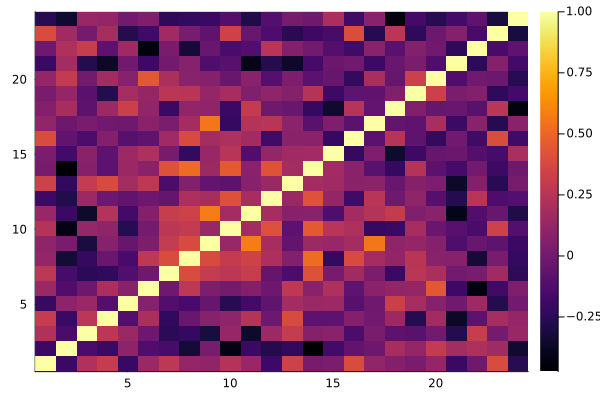

In [126]:
heatmap(cor(hcat(imag_pulses_cavity...)'))

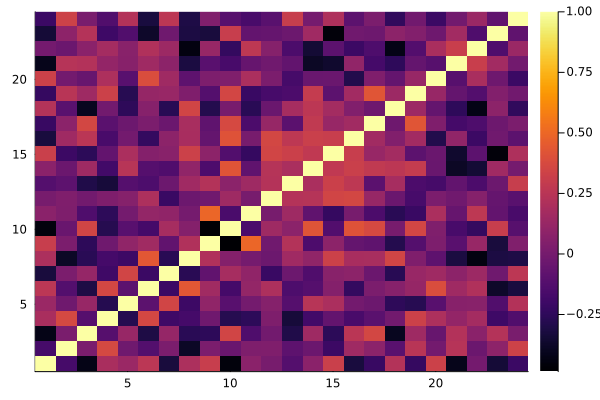

In [127]:
heatmap(cor(hcat(real_pulses_cavity...)'))

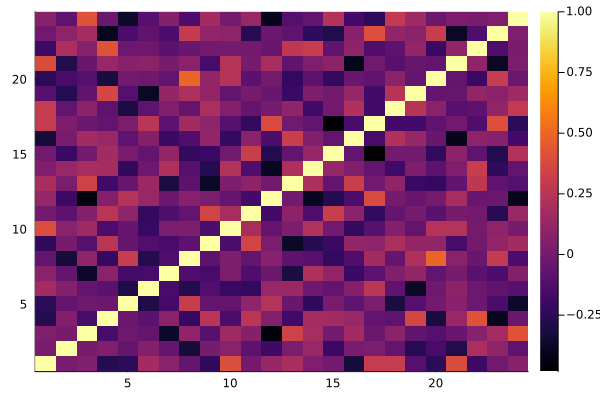

In [128]:
heatmap(cor(hcat(imag_pulses_qubit...)'))

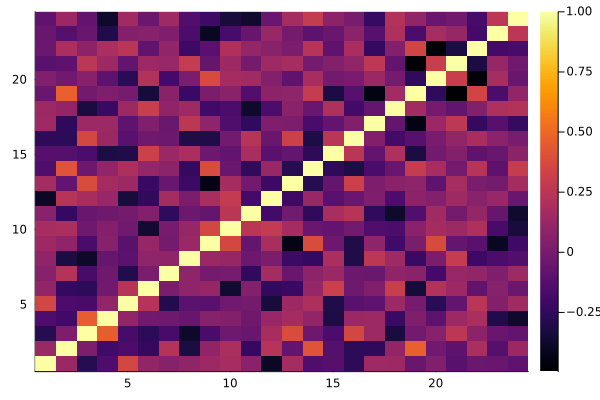

In [129]:
heatmap(cor(hcat(real_pulses_qubit...)'))

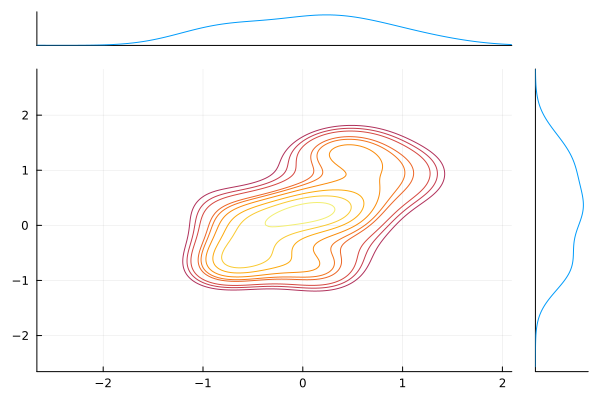

In [206]:
marginalkde(hcat(real_pulses_cavity...)[1,:],hcat(real_pulses_qubit...)[1,:])

# Amplitudes

In [155]:
real_pulses_cavity_time = []
imag_pulses_cavity_time = []
real_pulses_qubit_time = []
imag_pulses_qubit_time = []
T = 0.5

for i in 1:30
    amplitude_real_c(t) = chebyshev_amplitude(real_pulses_cavity[i], T, t)
    amplitude_real_q(t) = chebyshev_amplitude(real_pulses_qubit[i], T, t)
    amplitude_imag_c(t) = chebyshev_amplitude(imag_pulses_cavity[i], T, t)
    amplitude_imag_q(t) = chebyshev_amplitude(imag_pulses_qubit[i], T, t)
    
    amps_real_c = [amplitude_real_c(l)*10 for l in 0:T/(50):T]
    amps_real_q = [amplitude_real_q(l)*10 for l in 0:T/(50):T]
    amps_imag_c = [amplitude_imag_c(l)*10 for l in 0:T/(50):T]
    amps_imag_q = [amplitude_imag_q(l)*10 for l in 0:T/(50):T]

    push!(imag_pulses_cavity_time, amps_imag_c)
    push!(imag_pulses_qubit_time, amps_imag_q)
    push!(real_pulses_cavity_time, amps_real_c)
    push!(real_pulses_qubit_time, amps_real_q)
end

## correlation between subsequent points

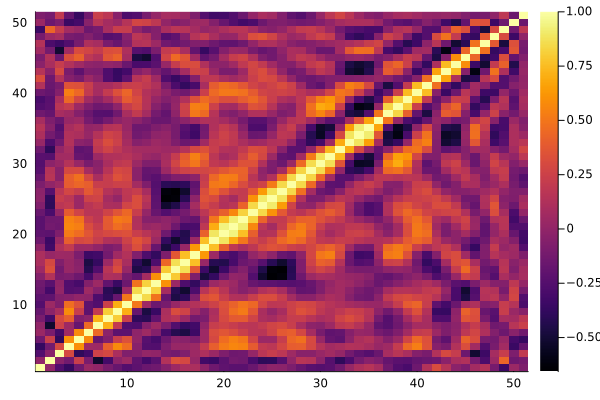

In [159]:
heatmap(cor(hcat(real_pulses_cavity_time...)'))

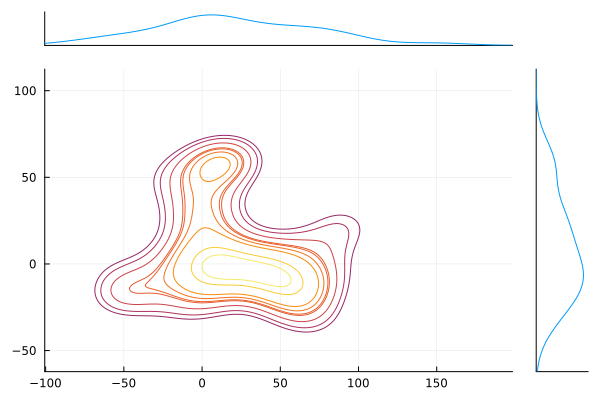

In [207]:
marginalkde(hcat(real_pulses_cavity_time...)[1,:],hcat(real_pulses_qubit_time...)[1,:])